## ME5413: Autonomous Mobile Robot  

### Homework 1: Perception  
Due date: 22 February 2024 (Thurs) - 2359 


### Task 1.1 Single-Object Tracking 

In [1]:
# load the necessary libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

Load data from the data folder

In [2]:
#load data from the data folder
seq_num = 1
file_path = f'./data/Task 1/seq_{seq_num}'

# load images from img folder
img_path = os.path.join(file_path, 'img')
img_list = os.listdir(img_path)
img_list.sort()

# load firsttrack file
t_1 = np.loadtxt(os.path.join(file_path, 'firsttrack.txt'),
                 delimiter=',')
t_1 = t_1.astype(int)

Using Template Matching

In [3]:
# get the template from the first image
x_0, y_0, w, h = t_1[0], t_1[1], t_1[2], t_1[3]
img = cv2.imread(str(os.path.join(img_path, img_list[0])))
temp = img[y_0:y_0 + h, x_0:x_0 + w]

# create a saving folder
saving_path = f'Task 1/seq_{seq_num}'
if not os.path.exists(saving_path):
    os.makedirs(saving_path)

# set a box
box_coord=np.zeros((len(img_list),4))
box_coord[0,:]=[x_0, y_0,w, h]

# create a list to store the tracking results
Results_TempMatch = []

# open the saving file
f = open(f'Task 1/seq_{seq_num}/Results_TempMatch.txt', 'w')

i = 0
for img_name in img_list:
    img = cv2.imread(str(os.path.join(img_path, img_name)))
    # set the window
    window_X0 = max(int(box_coord[i, 0] - w * 0.46), 0)
    window_Y0 = max(int(box_coord[i, 1] - h * 0.46), 0)
    window_X1 = min(int(box_coord[i, 0] + w * 1.92), img.shape[1])
    window_Y1 = min(int(box_coord[i, 1] + h * 1.92), img.shape[0])
    
    # Set the region of interest (roi)
    roi_window = img[window_Y0:window_Y1, window_X0:window_X1]
    # apply the template matching
    res = cv2.matchTemplate(roi_window, temp, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    Results_TempMatch.append([window_X0 + top_left[0], window_Y0 + top_left[1], window_X0 + bottom_right[0], window_Y0 + bottom_right[1]])
    x, y, x2, y2 = Results_TempMatch[-1]
    f.write(str(x) + ',' + str(y) + ',' + str(w) + ',' + str(h) + '\n')
    i += 1
    if i<= 99:
        box_coord[i] = [x, y, w, h]
    cv2.rectangle(img, (x, y), (x2, y2), (0, 255, 0), 2)
    cv2.imshow('img:', img)
    cv2.waitKey(30)
    
    # check if the user pressed the 'q' key
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
f.close()
cv2.destroyAllWindows()

Using Kalman Filter

In [4]:
# get the template from the first image
x_0, y_0, w, h = t_1[0], t_1[1], t_1[2], t_1[3]
img = cv2.imread(str(os.path.join(img_path, img_list[0])))
temp = img[y_0:y_0 + h, x_0:x_0 + w]

# initialize the kalman filter
kalman = cv2.KalmanFilter(4, 2)
kalman.measurementMatrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], np.float32)
kalman.transitionMatrix = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], np.float32)
kalman.processNoiseCov = np.eye(4, dtype=np.float32) * 0.5
# Measurement noise covariance
kalman.measurementNoiseCov = np.eye(2, dtype=np.float32) * 0.005 

# create a list to store the tracking results
Results_TempMatch_K = []
Results_Kalman = []

# create a list to store the tracking results
tracking_results_KF = []
f = open(f'Task 1/seq_{seq_num}/Results_Kalman.txt', 'w')

# set a box for kalman
box_coord_kalman=np.zeros((len(img_list),4))
box_coord_kalman[0,:]=[x_0, y_0,w, h]

i = 0
for img_name in img_list:
    img = cv2.imread(str(os.path.join(img_path, img_name)))
    # set the window
    window_X0 = max(int(box_coord_kalman[i, 0] - w * 0.46), 0)
    window_Y0 = max(int(box_coord_kalman[i, 1] - h * 0.46), 0)
    window_X1 = min(int(box_coord_kalman[i, 0] + w * 1.92), img.shape[1])
    window_Y1 = min(int(box_coord_kalman[i, 1] + h * 1.92), img.shape[0])
    
    # Set the region of interest (roi)
    roi_window = img[window_Y0:window_Y1, window_X0:window_X1]
    # apply the template matching
    res = cv2.matchTemplate(roi_window, temp, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    Results_TempMatch_K.append([top_left[0], top_left[1], bottom_right[0], bottom_right[1]])
    x, y, x2, y2 = Results_TempMatch_K[-1]
    i += 1
    if i<= 99:
        box_coord_kalman[i] = [window_X0 +x, window_Y0 +y, w, h]
    measurement = np.array([window_X0 + x, window_Y0 + y], np.float32)
    
        # Predict
    predicted = kalman.predict()
    # Update
    kalman.correct(measurement)
    updated_state = kalman.statePost
    n = i-1
    box_coord_kalman[n, 0] = updated_state[0]
    box_coord_kalman[n, 1] = updated_state[1]
    start_point = (int(box_coord_kalman[n, 0]), int(box_coord_kalman[n, 1]))
    end_point = (
        int(box_coord_kalman[n, 0] + box_coord_kalman[n, 2]),
        int(box_coord_kalman[n, 1] + box_coord_kalman[n, 3]),
    )
    Results_Kalman.append([int(box_coord_kalman[n, 0]), int(box_coord_kalman[n, 1]), int(box_coord_kalman[n, 0])+w, int(box_coord_kalman[n, 1])+h])
    cv2.rectangle(img, start_point, end_point, (0, 255, 0), 2)
    f.write(str(int(box_coord_kalman[n, 0])) + ',' + str(int(box_coord_kalman[n, 1])) + ',' + str(w) + ',' + str(h) + '\n')
    cv2.imshow('img:', img)
    cv2.waitKey(30)
    
    # check if the user pressed the 'q' key
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
f.close()
cv2.destroyAllWindows()

C:\Users\ZHUOYUAN\AppData\Local\Temp\ipykernel_35972\1555080733.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  box_coord_kalman[n, 0] = updated_state[0]
C:\Users\ZHUOYUAN\AppData\Local\Temp\ipykernel_35972\1555080733.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  box_coord_kalman[n, 1] = updated_state[1]


Some other standard OpenCV methods

In [5]:
# list some methods provided by opencv
# Set up tracker
tracker_types = ['BOOSTING', 'MIL', 'KCF', 'TLD', 'MEDIANFLOW', 'GOTURN', 'MOSSE', 'CSRT']
tracker_type = tracker_types[2]

if tracker_type == 'BOOSTING':
    tracker = cv2.legacy.TrackerBoosting_create()
if tracker_type == 'MIL':
    tracker = cv2.TrackerMIL_create()
if tracker_type == 'KCF':
    tracker = cv2.TrackerKCF_create()
if tracker_type == 'TLD':
    tracker = cv2.legacy.TrackerTLD_create()
if tracker_type == 'MEDIANFLOW':
    tracker = cv2.legacy.TrackerMedianFlow_create()
if tracker_type == 'GOTURN':
    tracker = cv2.TrackerGOTURN_create()
if tracker_type == 'MOSSE':
    tracker = cv2.legacy.TrackerMOSSE_create()
if tracker_type == "CSRT":
    tracker = cv2.TrackerCSRT_create()

x_0, y_0, w, h = t_1[0], t_1[1], t_1[2], t_1[3]
img = cv2.imread(str(os.path.join(img_path, img_list[0])))
ok = tracker.init(img, (x_0, y_0, w, h))

# create a list to store the tracking results
tracking_results_tracker = []
f = open(f'Task 1/seq_{seq_num}/Results_Other.txt', 'w')

for img_name in img_list:
    img = cv2.imread(str(os.path.join(img_path, img_name)))
    ok, bbox = tracker.update(img)
    if ok:
        tracking_results_tracker.append([int(bbox[0]), int(bbox[1]), int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])])
        # save size_x, size_y, center_x, center_y in the txt file
        f.write(str(bbox[0]) + ',' + str(bbox[1]) + ',' + str(bbox[2]) + ',' + str(bbox[3]) + '\n')
        p1 = (int(bbox[0]), int(bbox[1]))
        p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
        cv2.rectangle(img, p1, p2, (255, 0, 0), 2)
    cv2.imshow('Tracking', img)
    cv2.waitKey(30)
f.close()
cv2.destroyAllWindows()

Load the ground truth

In [6]:
# load the ground truth
GT = np.loadtxt(os.path.join(file_path, 'groundtruth.txt'),     
                delimiter=',')
GT = GT.astype(int)

# create a list to store the tracking results
Results_GT = []
time_counter = 0
for img_name in img_list:
    x, y, w, h = GT[time_counter][0], GT[time_counter][1], GT[time_counter][2], GT[time_counter][3]
    time_counter += 1
    img = cv2.imread(str(os.path.join(img_path, img_name)))
    Results_GT.append([x, y, x + w, y + h])
    # cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 2)
    # cv2.imshow('img', img)
    # cv2.waitKey(100)
    
        # check if the user pressed the 'q' key
        # if cv2.waitKey(1) & 0xFF == ord('q'):
        #     break
    cv2.destroyAllWindows()

Evaluate the performance of the Single object tracking algorithm and visualise the results. 


The average overlap ratio for the template matching method is:  0.5773952441773877
The average overlap ratio for the Kalman filter method is:  0.5765822736652965
The average overlap ratio for the tracker method is:  0.6534690910150678


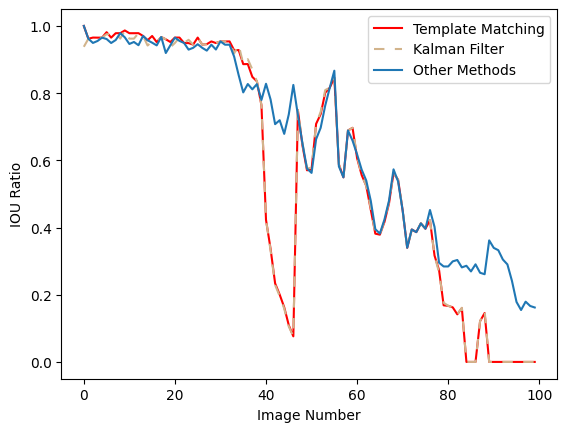

In [7]:
# define the IOU calculation function
def IOU_ratio(rect1, rect2):
    x1, y1, x2, y2 = rect1
    x3, y3, x4, y4 = rect2
    x5, y5 = max(x1, x3), max(y1, y3)
    x6, y6 = min(x2, x4), min(y2, y4) 
    overlap = max(0, x6 - x5) * max(0, y6 - y5)
    area_1 = (x2 - x1) * (y2 - y1)
    area_2 = (x4 - x3) * (y4 - y3)
    union = area_1 + area_2 - overlap
    return overlap / union

# calculate the IOU ratio
IOU_ratios_TM = [IOU_ratio(Results_GT[i], Results_TempMatch[i]) for i in range(len(Results_GT))]
IOU_ratios_KF = [IOU_ratio(Results_GT[i], Results_Kalman[i]) for i in range(len(Results_GT))]
IOU_ratios_Other = [IOU_ratio(Results_GT[i], tracking_results_tracker[i]) for i in range(len(Results_GT))]
print('The average overlap ratio for the template matching method is: ', np.mean(IOU_ratios_TM))
print('The average overlap ratio for the Kalman filter method is: ', np.mean(IOU_ratios_KF))
print('The average overlap ratio for the tracker method is: ', np.mean(IOU_ratios_Other))

# plot the overlap ratio
plt.plot(IOU_ratios_TM, label='Template Matching', color='red')
plt.plot(IOU_ratios_KF, label='Kalman Filter',linestyle=(0, (5, 5)), color='#D2B48C')
plt.plot(IOU_ratios_Other, label='Other Methods')
plt.xlabel('Image Number')
plt.ylabel('IOU Ratio')
plt.legend()
plt.savefig(f'Task 1/seq_{seq_num}/IOU_Ratio.png')
plt.show()

Propose Improvements to the work if possible: